### Day 2
#### 基于HST/EGS的图像提取及结构测量
* 作者: 朱帅儒（394，上海天文台）

* 更新于 2022-07-28

In [123]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.stats import SigmaClip
from astropy.nddata import Cutout2D
from astropy.table import Table
from astropy.convolution import convolve
from astropy.visualization import ZScaleInterval

from photutils import CircularAperture, aperture_photometry
from photutils.background import SExtractorBackground, Background2D
from photutils.segmentation import (detect_threshold, 
                                    detect_sources, 
                                    make_2dgaussian_kernel, 
                                    deblend_sources,
                                    SourceCatalog)
from photutils.utils import circular_footprint


#### 读取图像

Text(0.5, 1.0, 'EGS Images')

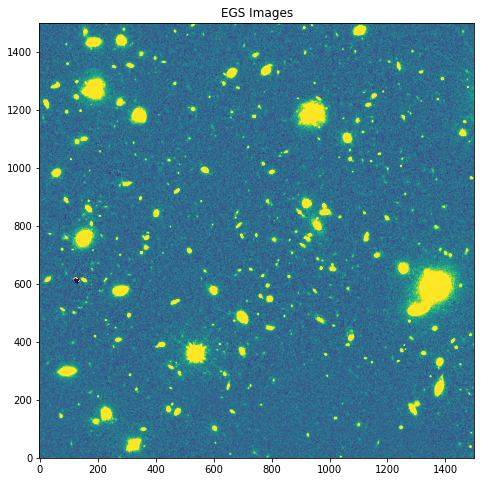

In [11]:
fig, ax = plt.subplots(figsize=(8,8))
# 读取文件头
header = fits.getheader("data/hst_egs.fits")
# 读取文件
image = fits.getdata("data/hst_egs.fits")
zscale = ZScaleInterval()
vmin, vmax = zscale.get_limits(image)

ax.imshow(image, vmin=vmin, vmax=vmax, origin="lower")
ax.set_title("EGS Images")

#### 扣除天光背景

* 这里使用了SExtractor软件的计算方法

In [25]:
# Mask objects
bkg_estimator = SExtractorBackground()
sigma_clip = SigmaClip(sigma=3.0, maxiters=10)

threshold = detect_threshold(image, nsigma=2.0, sigma_clip=sigma_clip)
segment_img = detect_sources(image, threshold, npixels=10)

footprint = circular_footprint(radius=10)
mask = segment_img.make_source_mask(footprint=footprint)

bkg = Background2D(image, (50, 50), filter_size=(3, 3), mask = mask,
                    sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

image_subtracted = image - bkg.background
rms_map = bkg.background_rms

#### 源探测
* 进行源探测前首先利用Gauss filter进行平滑，对暗弱源进行信号增强
* Filter的选择：选择Filter的FWHM大致与PSF的FWHM相同

In [97]:
# Prepare the filter 
# FWHM = 4
fwhm = 4.0
kernel=make_2dgaussian_kernel(fwhm,size=7)
threshold=detect_threshold(image_subtracted, nsigma=3)
# Source detection
conv_image = convolve(image_subtracted, kernel.array)
segmentation=detect_sources(conv_image, threshold, npixels=15) 
# Deblend
segm_deblend=deblend_sources(conv_image,segmentation,npixels=15, nlevels=64,
                                contrast=0.01)
# Make Catalog
cat=SourceCatalog(image_subtracted, segm_deblend, kernel=kernel, error=rms_map)

  0%|          | 0/247 [00:00<?, ?it/s]

#### 准备每个源的image cutout以及mask cutout

In [114]:
bonding_boxes = cat.bbox

for i, rows in enumerate(cat.to_table()):
    segment_copy = np.copy(segm_deblend.data)

    x, y = rows["xcentroid"]+1, rows["ycentroid"]+1
    size = bonding_boxes[i].shape
    size = size[0]*5, size[1]*5
    image_cutout = Cutout2D(image_subtracted, (x, y), size).data
    segm_cutout = Cutout2D(segment_copy, (x, y), size).data
    
    label = rows["label"]
    segm_cutout[segm_cutout==label] = 0

    fits.writeto("outputs/sci_cutout/{:d}_sci.fits".format(label),
                    image_cutout, overwrite=True)
    fits.writeto("outputs/mask_cutout/{:d}_mask.fits".format(label),
                    segm_cutout, overwrite=True)

#### 展示每个源的Kron aperture以及Deblend Segmentation

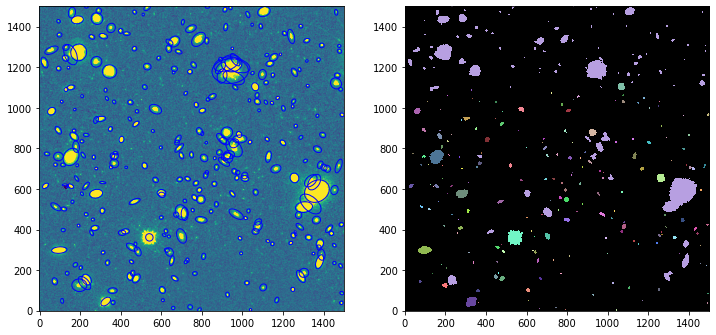

In [115]:
fig, axes = plt.subplots(figsize=(12,6),ncols=2)

axes[0].imshow(image_subtracted, vmin=vmin, vmax=vmax, origin="lower")
cat.plot_kron_apertures(axes=axes[0], color="blue", lw=1)

axes[1].imshow(segm_deblend,cmap=segm_deblend.cmap,
                vmin=0, vmax=200, origin='lower',interpolation='nearest')

#### 圆孔径测光

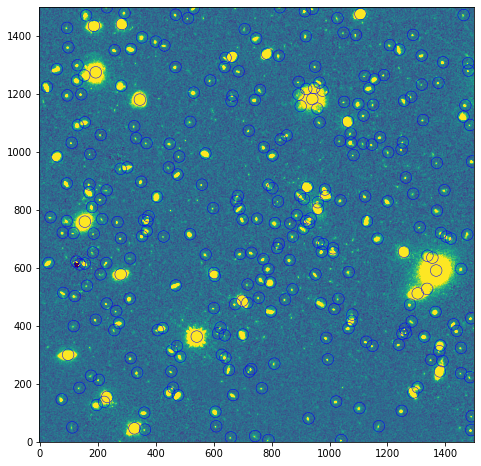

In [122]:
fig, ax = plt.subplots(figsize=(8, 8))

positions=cat.centroid+1
aperture=CircularAperture(positions,r=20)

ax.imshow(image_subtracted, vmin=vmin, vmax=vmax, origin="lower")
ap_patches = aperture.plot(color='blue', lw=0.5,label='Photometry aperture')

phot_table = aperture_photometry(image_subtracted, aperture, error=rms_map)

In [150]:
catalog = Table()
master_catalog = cat.to_table()
# Position params
catalog["x"] = master_catalog["xcentroid"]
catalog["y"] = master_catalog["ycentroid"]
# Structure params
catalog["theta"] = master_catalog["orientation"]
catalog["e"] = master_catalog["eccentricity"]
catalog["a_image"] = master_catalog["semimajor_sigma"]
catalog["b_image"] = master_catalog["semiminor_sigma"]
catalog["R50"] = cat.fluxfrac_radius(0.5)
# Photometry
catalog["flux_auto"] = master_catalog["kron_flux"]
catalog["fluxerr_auto"] = master_catalog["kron_fluxerr"]
catalog["flux_aper"] = phot_table["aperture_sum"]
catalog["fluxerr_aper"] = phot_table["aperture_sum_err"]

catalog.write("catalog.txt", format="ascii.commented_header",
                overwrite=True)

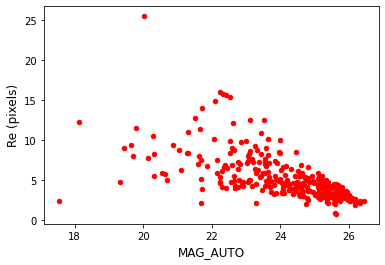

In [152]:
fig, ax = plt.subplots()

mags = -2.5*np.log10(catalog["flux_auto"]) + 25.946

ax.scatter(mags, catalog["R50"], s=20, color='red')
ax.set_xlabel('MAG_AUTO',fontsize=12)
ax.set_ylabel('Re (pixels)',fontsize=12)

fig.savefig("mag_re.jpg")